<a href="https://colab.research.google.com/github/Noel1805/Inteligencia_Artificial/blob/main/Twiter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea
Confirmar que el análisis de agrupamiento, incluyendo el código, la ejecución y las explicaciones, se ha revisado correctamente.

## Análisis de Clustering de Datos

Este cuaderno realiza un análisis completo de clustering utilizando el algoritmo K-Means sobre un conjunto de datos específico. El objetivo es identificar grupos naturales dentro de los datos y evaluar la calidad de estos agrupamientos. Se enfoca en las características 'op', 'co', 'ex' y 'ag' según la solicitud del usuario.


### 1. Configuración Inicial e Importación de Librerías

Primero, montamos Google Drive para acceder al archivo de datos y cargamos todas las librerías necesarias para el análisis.


In [76]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore') # Ignorar warnings para una salida más limpia


### 2. Carga y Exploración Inicial del Dataframe

Cargamos el archivo `analisis.csv` y realizamos una primera exploración para entender su estructura y contenido. Se corregirá la ruta para asegurar la lectura desde Google Drive.


Primeras 5 filas del dataframe:


,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4



Estadísticas descriptivas del dataframe:


,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678866,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000



Cantidad de elementos por categoría:


,0
categoria,
1,27
2,34
3,9
4,19
5,4
6,8
7,17
8,16
9,6



Histogramas de las características numéricas:


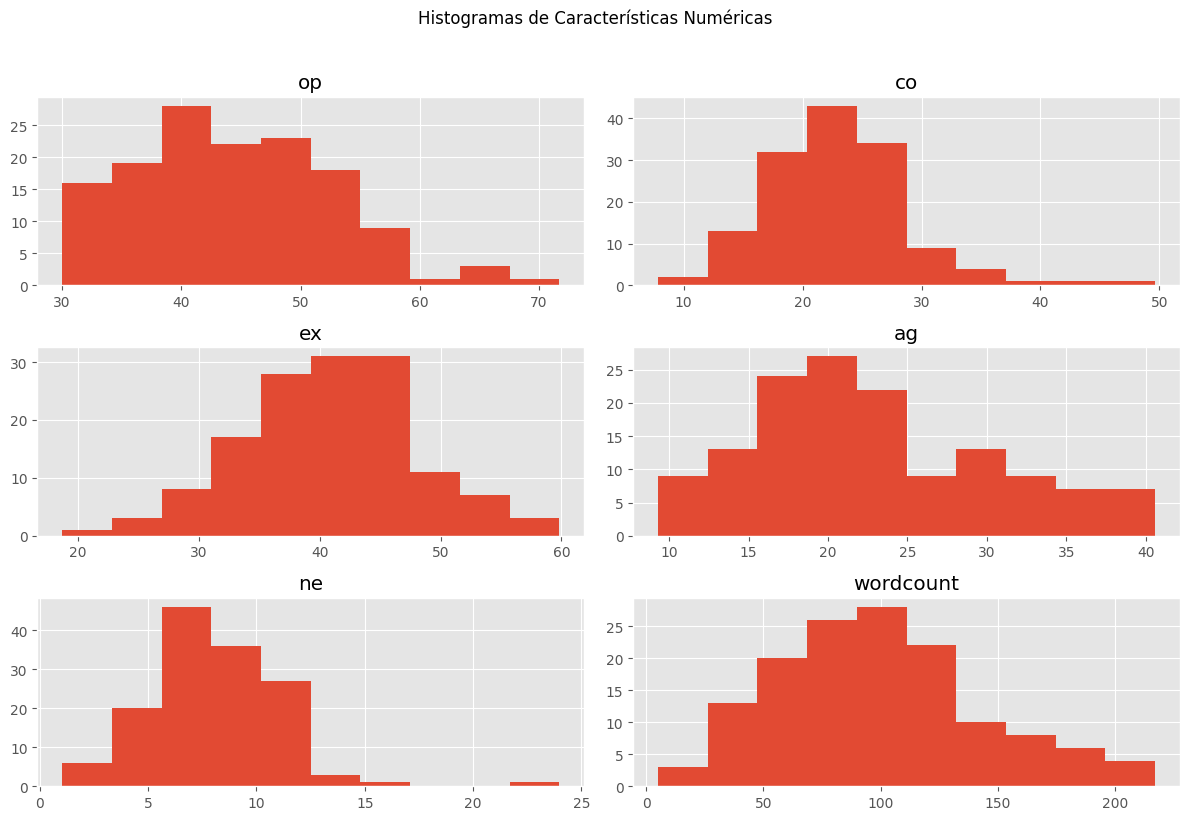

In [78]:
# Cargar el dataframe desde Google Drive
dataframe = pd.read_csv(r"/content/drive/MyDrive/analisis.csv")

print("Primeras 5 filas del dataframe:")
display(dataframe.head())

print("\nEstadísticas descriptivas del dataframe:")
display(dataframe.describe())

print("\nCantidad de elementos por categoría:")
display(dataframe.groupby("categoria").size())

print("\nHistogramas de las características numéricas:")
dataframe.drop(columns=["categoria"]).hist(figsize=(12, 8))
plt.suptitle('Histogramas de Características Numéricas', y=1.02)
plt.tight_layout()
plt.show()


### 3. Preparación de Datos para Clustering y Pairplot

Seleccionamos las características solicitadas ('op', 'co', 'ex', 'ag') para el clustering y creamos los arrays `x` e `y`. Además, generamos un pairplot para visualizar las relaciones entre estas características y las categorías.


Características seleccionadas para el clustering: ['op', 'co', 'ex', 'ag']
Shape de x (con las 4 características seleccionadas): (140, 4)
Shape de y (etiquetas de categoría): (140,)

Pairplot de las características seleccionadas por categoría:


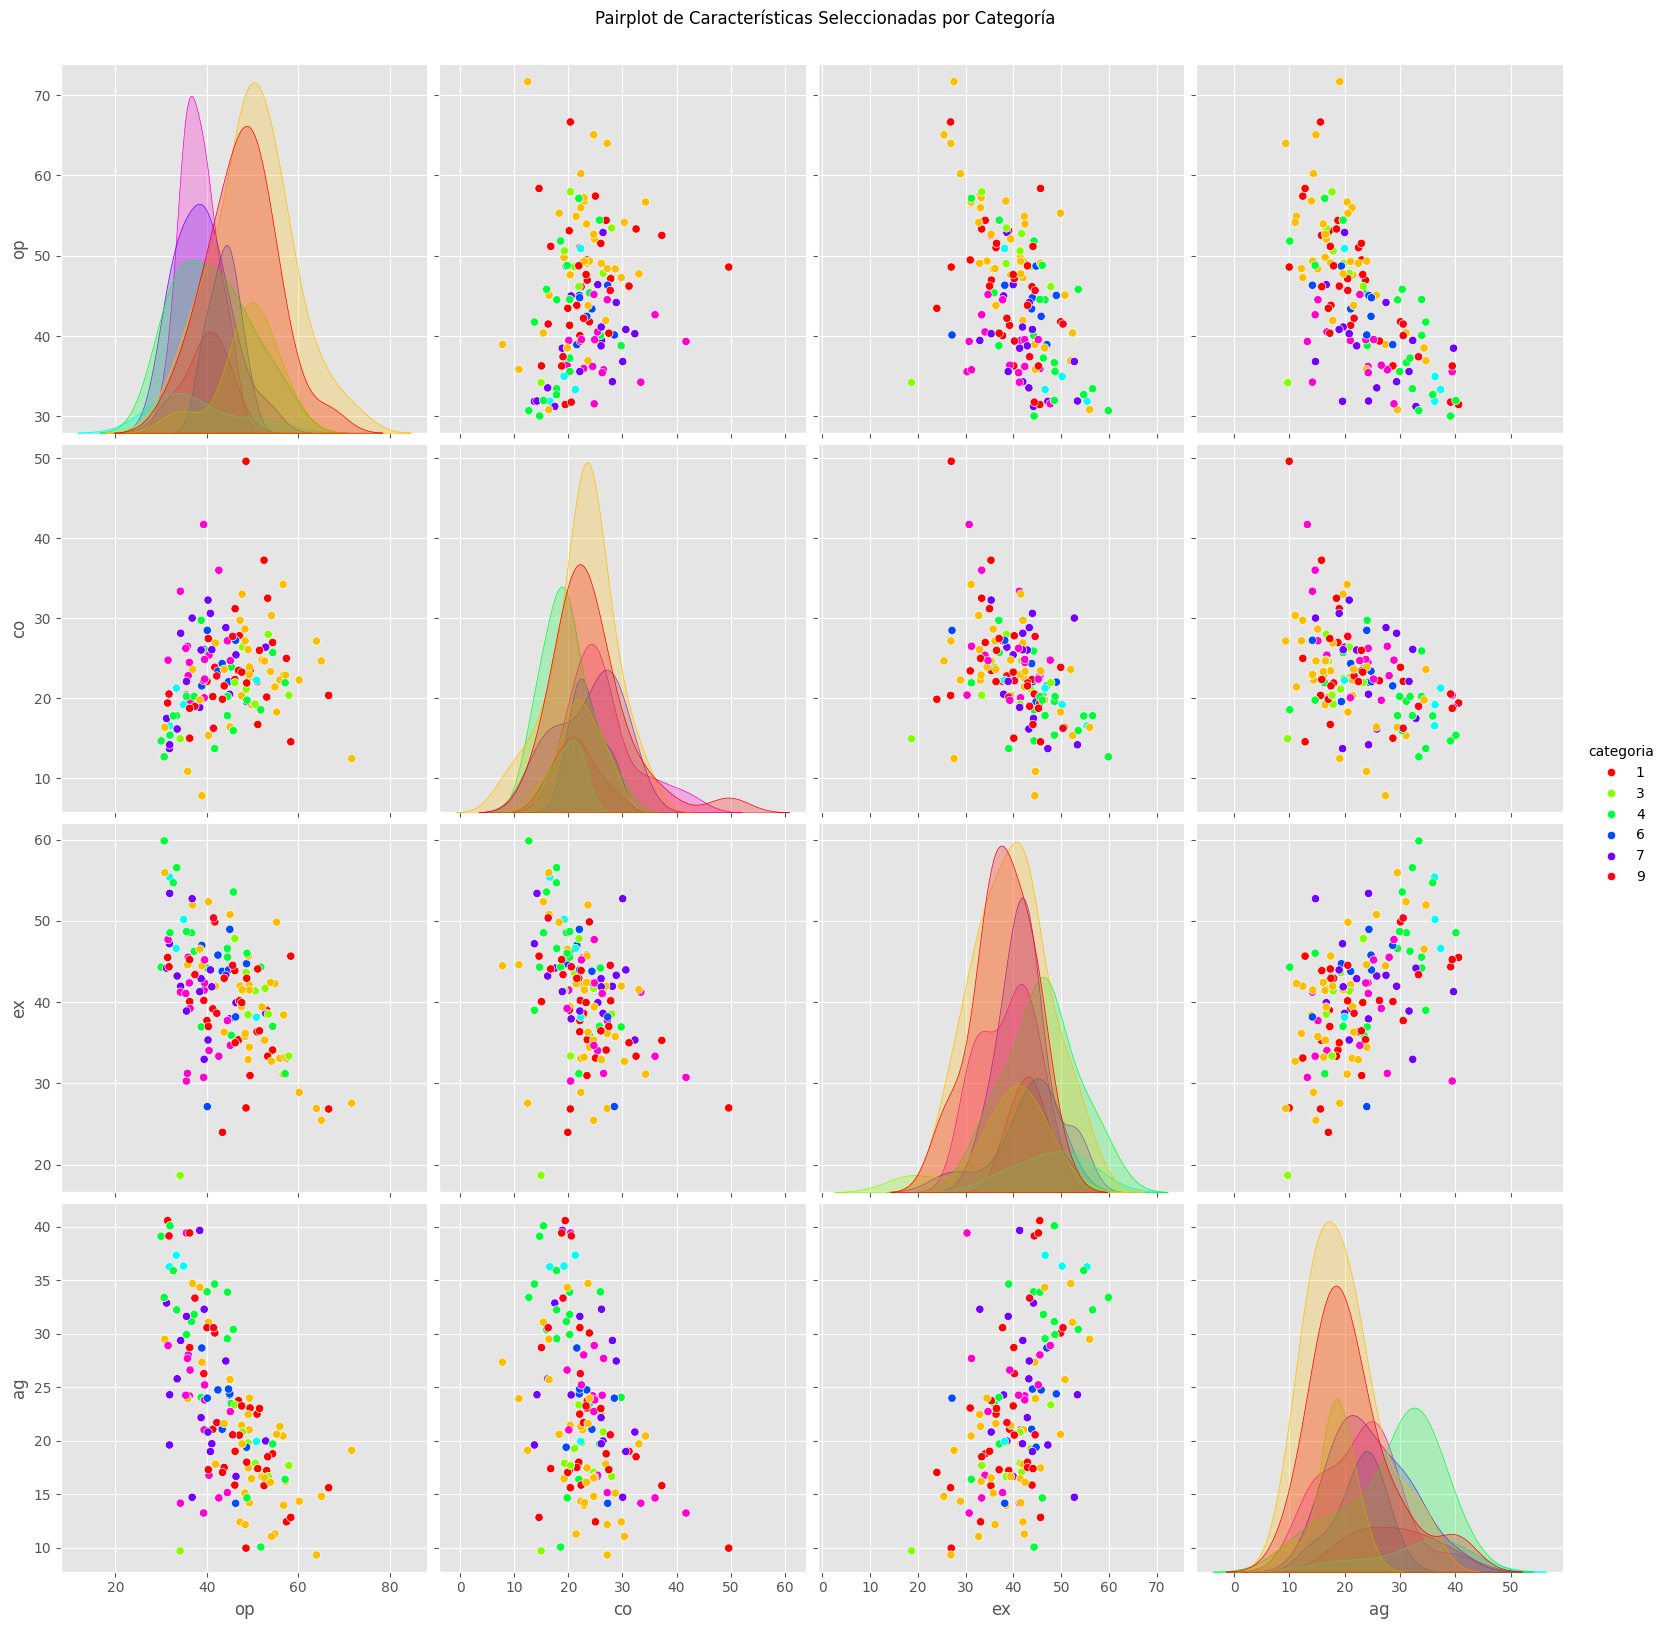

In [79]:
columnas = ["op","co","ex","ag"]
seleccionadas = columnas # Se seleccionan directamente las 4 columnas pedidas por el usuario

# Crear los arrays x (características) e y (etiquetas de categoría)
x = np.array(dataframe[seleccionadas])
y = np.array(dataframe["categoria"])

print(f"Características seleccionadas para el clustering: {seleccionadas}")
print(f"Shape de x (con las 4 características seleccionadas): {x.shape}")
print(f"Shape de y (etiquetas de categoría): {y.shape}")

print("\nPairplot de las características seleccionadas por categoría:")
sb.pairplot(dataframe.dropna(), hue="categoria", height=4, vars=seleccionadas, kind="scatter", palette="hsv")
plt.suptitle('Pairplot de Características Seleccionadas por Categoría', y=1.02)
plt.show()


### 4. Visualización 3D Inicial de los Datos

Visualizamos las primeras tres características de los datos en un gráfico 3D, coloreando los puntos según sus categorías originales para una inspección visual inicial.


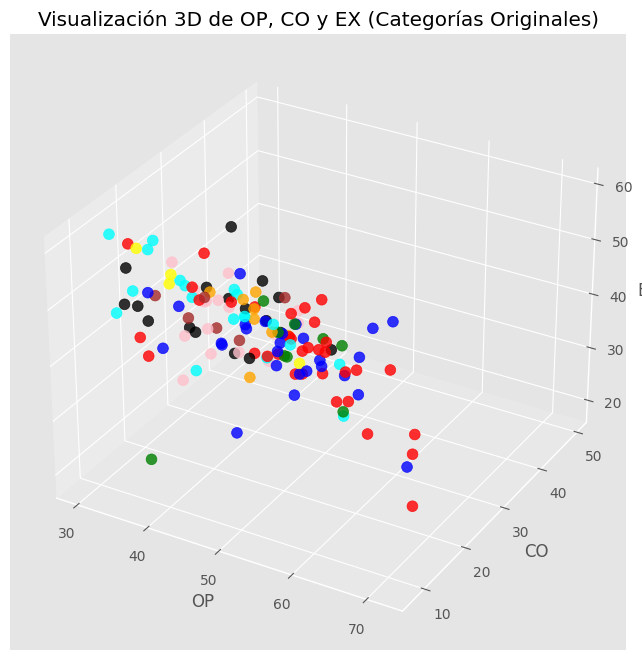

In [80]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

colores_originales = ["blue","red","green","cyan","yellow","orange","black","pink","brown","purple"]

asignar_colores_originales = []
# Ajustar el índice para que coincida con los colores si las categorías empiezan en 1
for row in y:
    if row -1 < len(colores_originales):
        asignar_colores_originales.append(colores_originales[row-1])
    else:
        asignar_colores_originales.append('gray') # Color por defecto si no hay suficiente colores

# Para la visualización 3D, se usan las primeras 3 características de las seleccionadas
ax.scatter(x[:,0], x[:,1], x[:,2], c=asignar_colores_originales, s=60, alpha=0.8)
ax.set_xlabel(seleccionadas[0].upper())
ax.set_ylabel(seleccionadas[1].upper())
ax.set_zlabel(seleccionadas[2].upper())
ax.set_title(f'Visualización 3D de {seleccionadas[0].upper()}, {seleccionadas[1].upper()} y {seleccionadas[2].upper()} (Categorías Originales)')
plt.show()


### 5. Determinación del Número Óptimo de Clusters (K)

Empleamos diferentes metodologías (Elbow, Silhouette, Calinski-Harabasz, Davies-Bouldin) para determinar el número óptimo de clusters (K).


K elegido por Elbow (heurística): 2
K elegido por Silhouette (máx): 2
K elegido por Calinski-Harabasz (máx): 2
K elegido por Davies-Bouldin (mín): 17


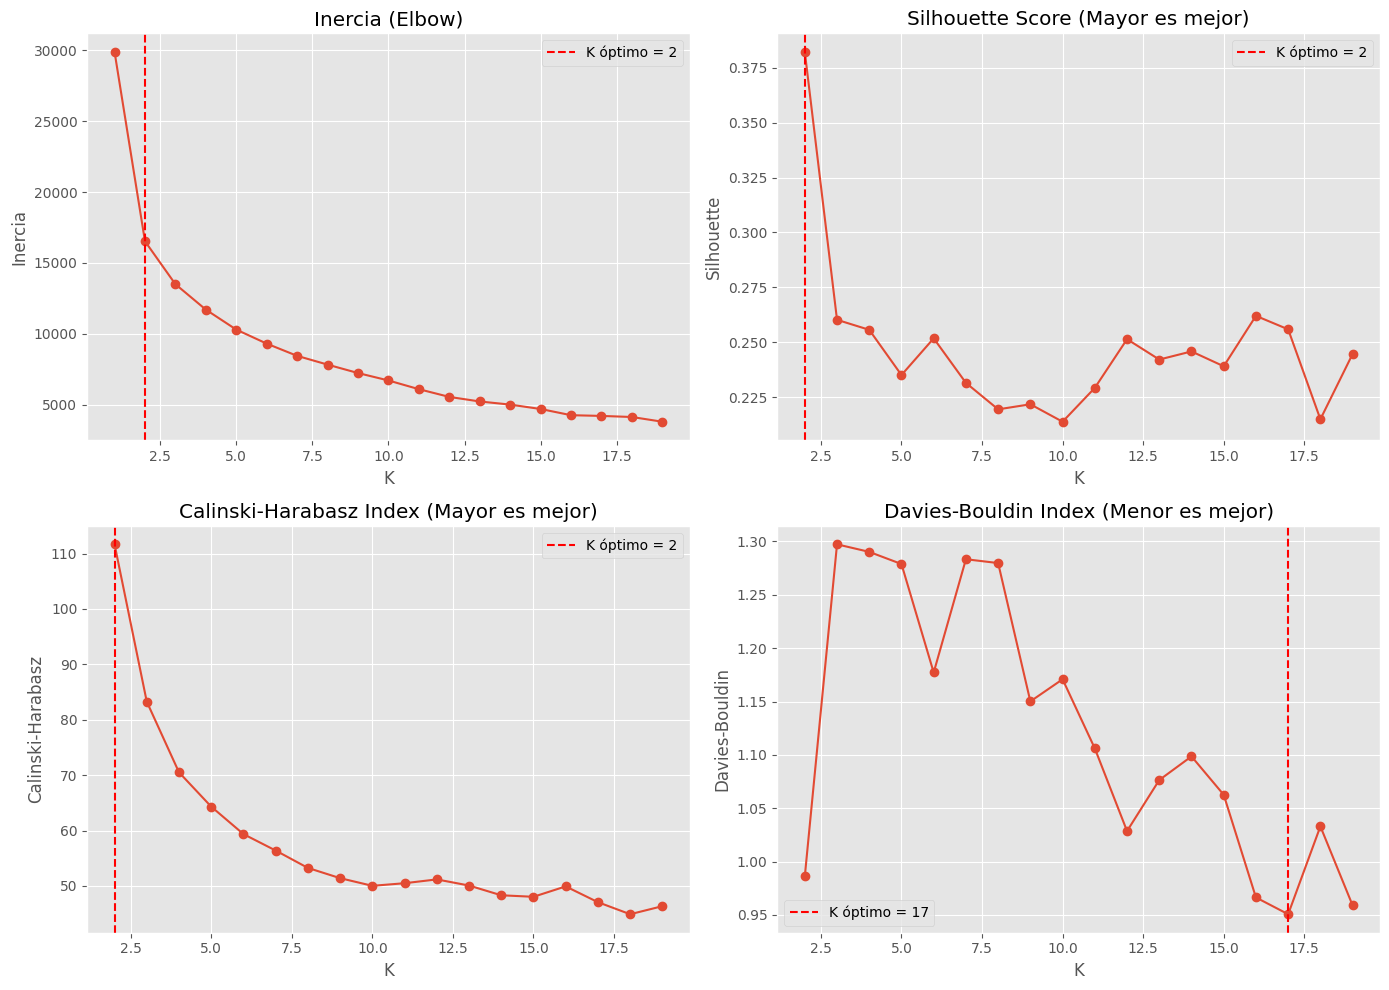

In [81]:
k_values = list(range(1, 20))

inertia = []
silhouettes = []
calinski = []
davies = []

for i in k_values:
    km = KMeans(n_clusters=i, random_state=0, n_init=10) # n_init=10 para evitar warnings
    if i == 1:
        km.fit(x)
        inertia.append(km.inertia_)
        silhouettes.append(np.nan) # No se puede calcular Silhouette para k=1
        calinski.append(np.nan)    # No se puede calcular Calinski para k=1
        davies.append(np.nan)      # No se puede calcular Davies para k=1
    else:
        labels = km.fit_predict(x)
        inertia.append(km.inertia_)
        silhouettes.append(silhouette_score(x, labels))
        calinski.append(calinski_harabasz_score(x, labels))
        davies.append(davies_bouldin_score(x, labels))

# Encontrar los K óptimos según cada métrica
sil_best = k_values[np.nanargmax(silhouettes)] if not np.all(np.isnan(silhouettes)) else k_values[0]
cal_best = k_values[np.nanargmax(calinski)] if not np.all(np.isnan(calinski)) else k_values[0]
dav_best = k_values[np.nanargmin(davies)] if not np.all(np.isnan(davies)) else k_values[0]

# Heurística para Elbow: máximo de la segunda diferencia absoluta de la inercia
elbow_best = k_values[0]
if len(inertia) >= 3:
    second_diff = np.diff(inertia, n=2)  # Calcula la segunda derivada de la inercia
    elbow_idx = np.argmax(np.abs(second_diff)) + 1 # +1 porque diff reduce en 2, y queremos el punto 'codo'
    elbow_best = k_values[elbow_idx]

print(f"K elegido por Elbow (heurística): {elbow_best}")
print(f"K elegido por Silhouette (máx): {sil_best}")
print(f"K elegido por Calinski-Harabasz (máx): {cal_best}")
print(f"K elegido por Davies-Bouldin (mín): {dav_best}")

# Graficar cada métrica
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

axes[0].plot(k_values, inertia, marker='o')
axes[0].set_title('Inercia (Elbow)')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inercia')
axes[0].axvline(elbow_best, color='red', linestyle='--', label=f'K óptimo = {elbow_best}')
axes[0].legend()

axes[1].plot(k_values, silhouettes, marker='o')
axes[1].set_title('Silhouette Score (Mayor es mejor)')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette')
axes[1].axvline(sil_best, color='red', linestyle='--', label=f'K óptimo = {sil_best}')
axes[1].legend()

axes[2].plot(k_values, calinski, marker='o')
axes[2].set_title('Calinski-Harabasz Index (Mayor es mejor)')
axes[2].set_xlabel('K')
axes[2].set_ylabel('Calinski-Harabasz')
axes[2].axvline(cal_best, color='red', linestyle='--', label=f'K óptimo = {cal_best}')
axes[2].legend()

axes[3].plot(k_values, davies, marker='o')
axes[3].set_title('Davies-Bouldin Index (Menor es mejor)')
axes[3].set_xlabel('K')
axes[3].set_ylabel('Davies-Bouldin')
axes[3].axvline(dav_best, color='red', linestyle='--', label=f'K óptimo = {dav_best}')
axes[3].legend()

plt.tight_layout()
plt.show()


### 6. Creación de Modelos K-Means y Centros de Cluster

Se crean los modelos K-Means utilizando los valores de K determinados por cada métrica. Se imprimen los conteos de usuarios por cluster y las coordenadas de los centroides.


In [82]:
ks = {
    "elbow": elbow_best,
    "silhouette": sil_best,
    "calinski": cal_best,
    "davies": dav_best
}

models = {}
colores = ["blue","red","green","cyan","yellow","orange","black","pink","brown","purple", "magenta", "lime", "teal", "navy", "maroon", "olive", "coral", "gold", "silver", "violet", "indigo", "turquoise", "salmon", "plum", "orchid", "tan", "lavender", "beige", "peach", "mint", "apricol", "charcoal", "ivory"]

for name, k in ks.items():
    km = KMeans(n_clusters=int(k), random_state=0, n_init=10).fit(x)
    models[name] = km
    labels = km.labels_
    counts = np.bincount(labels, minlength=km.n_clusters)
    print(f"\n{'='*80}")
    print(f"MODELO: {name.upper()} (k={k})")
    print(f"{'='*80}")
    print(f"  Conteo de usuarios por cluster: {counts}")
    print(f"  Centroides:\n{km.cluster_centers_}")



MODELO: ELBOW (k=2)
  Conteo de usuarios por cluster: [58 82]
  Centroides:
[[37.34464671 20.04801193 45.74797869 30.10473653]
 [49.41528312 25.0489543  37.23947741 17.83559991]]

MODELO: SILHOUETTE (k=2)
  Conteo de usuarios por cluster: [58 82]
  Centroides:
[[37.34464671 20.04801193 45.74797869 30.10473653]
 [49.41528312 25.0489543  37.23947741 17.83559991]]

MODELO: CALINSKI (k=2)
  Conteo de usuarios por cluster: [58 82]
  Centroides:
[[37.34464671 20.04801193 45.74797869 30.10473653]
 [49.41528312 25.0489543  37.23947741 17.83559991]]

MODELO: DAVIES (k=17)
  Conteo de usuarios por cluster: [18 11  4  5 16 19 16 12  2  8  2  2  4  6  5  5  5]
  Centroides:
[[51.13688978 20.57683483 43.47283222 16.47756172]
 [37.03795855 22.79924109 47.10197955 30.98636009]
 [54.1773595  33.608368   33.12453375 16.442867  ]
 [65.5299666  21.4103088  27.1434742  14.6252708 ]
 [47.92578869 23.7890905  36.80581856 22.28512794]
 [41.32463811 24.08851174 43.63026942 22.52208968]
 [43.42152256 29.48480

### 7. Visualización 3D de los Clusters y Centroides

Graficamos los clusters y sus centroides en 3D para cada modelo. Se utilizan las primeras tres características de las seleccionadas.


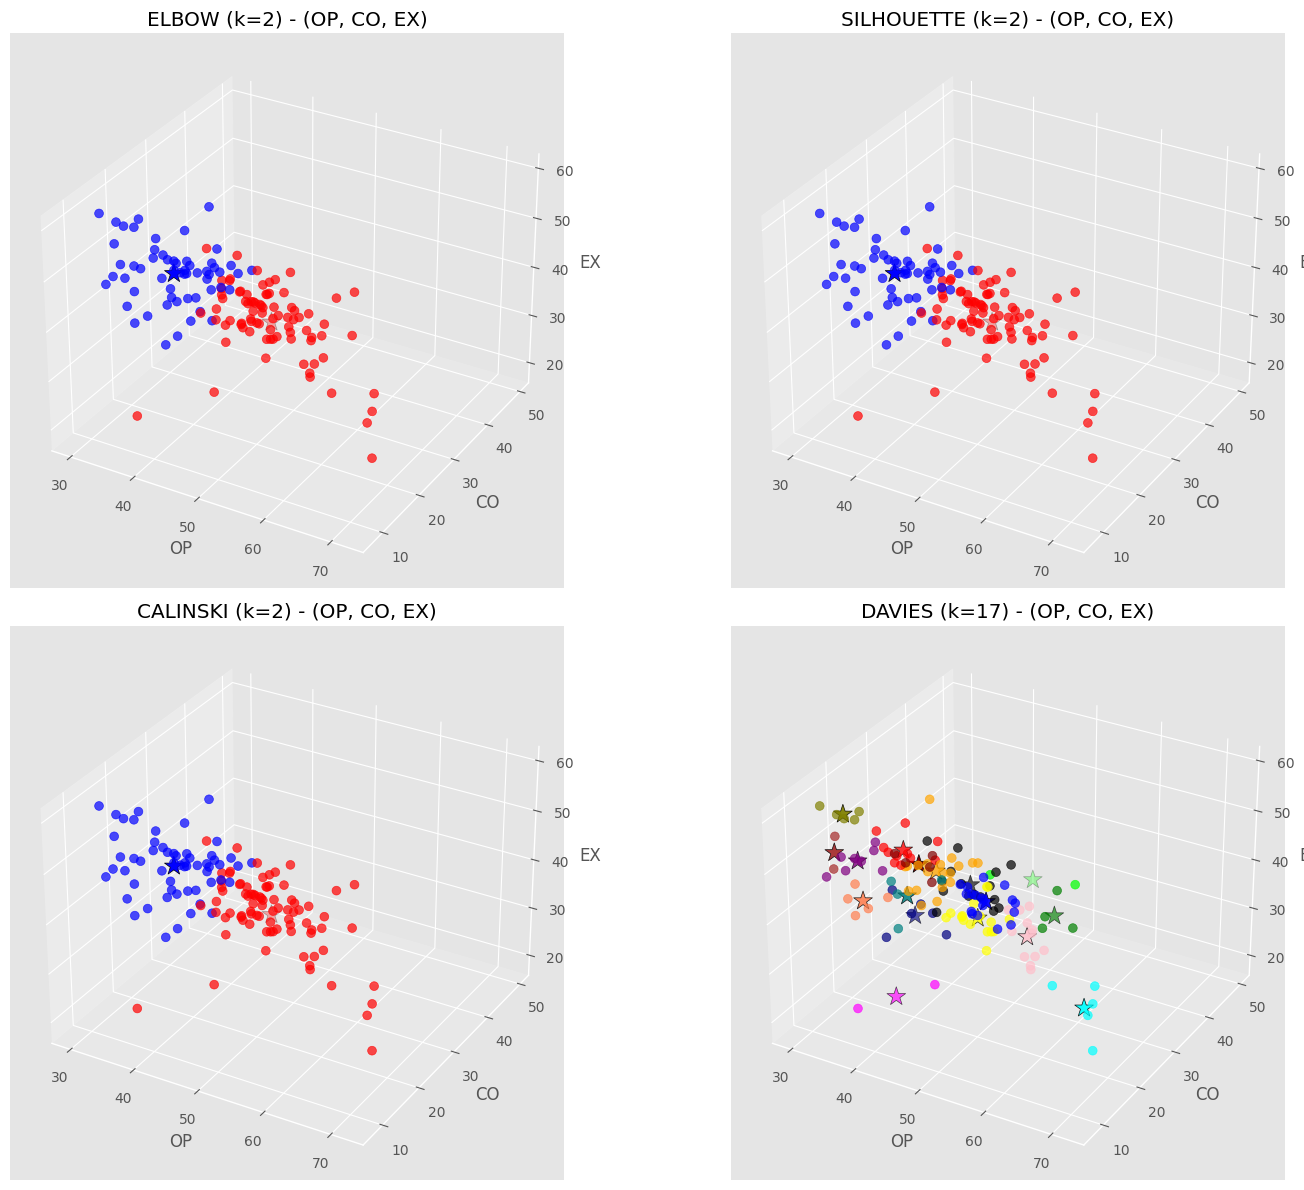

In [75]:
fig = plt.figure(figsize=(16, 12))

for i, (name, km) in enumerate(models.items(), start=1):
    ax = fig.add_subplot(2, 2, i, projection="3d")
    labels = km.predict(x)

    asignar = [colores[l] if l < len(colores) else "gray" for l in labels]
    C = km.cluster_centers_

    ax.scatter(x[:,0], x[:,1], x[:,2], c=asignar, s=40, alpha=0.7)
    ax.scatter(C[:,0], C[:,1], C[:,2], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    ax.set_title(f"{name.upper()} (k={km.n_clusters}) - ({seleccionadas[0].upper()}, {seleccionadas[1].upper()}, {seleccionadas[2].upper()})")
    ax.set_xlabel(seleccionadas[0].upper())
    ax.set_ylabel(seleccionadas[1].upper())
    ax.set_zlabel(seleccionadas[2].upper())

plt.tight_layout()
plt.show()


### 8. Visualización 2D de los Clusters y Centroides

Graficamos los clusters y sus centroides en proyecciones 2D para cada modelo (pares de las primeras tres características).


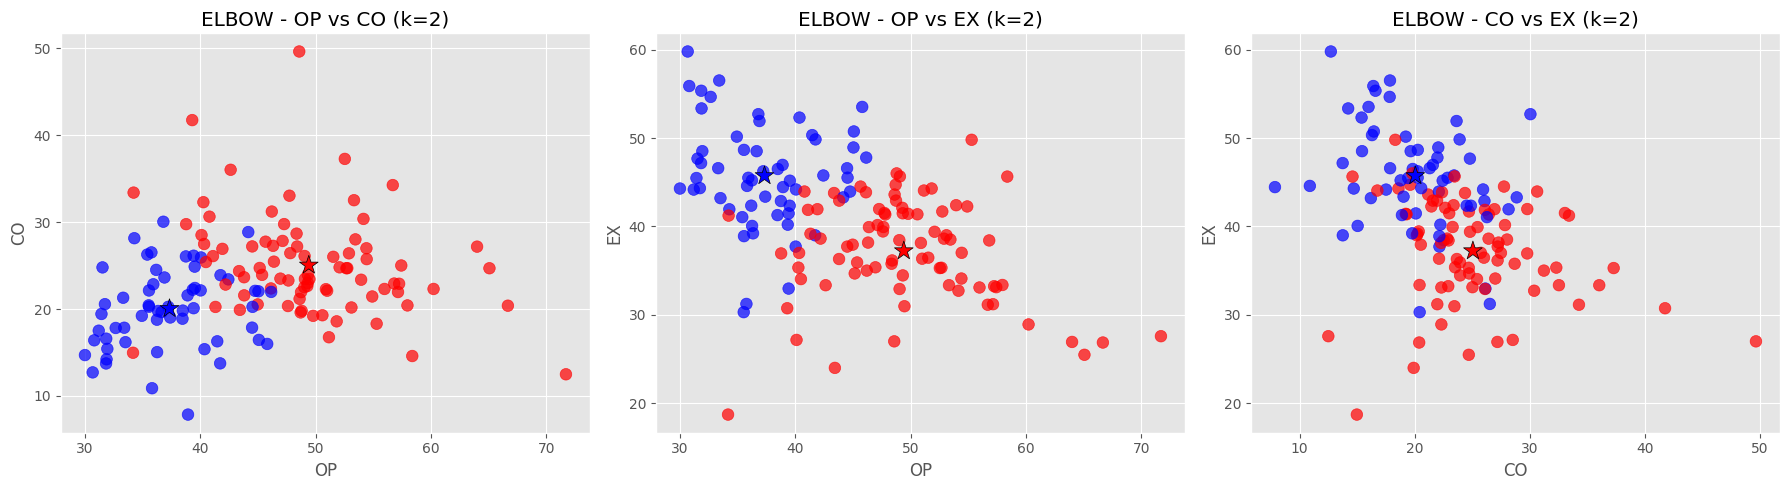

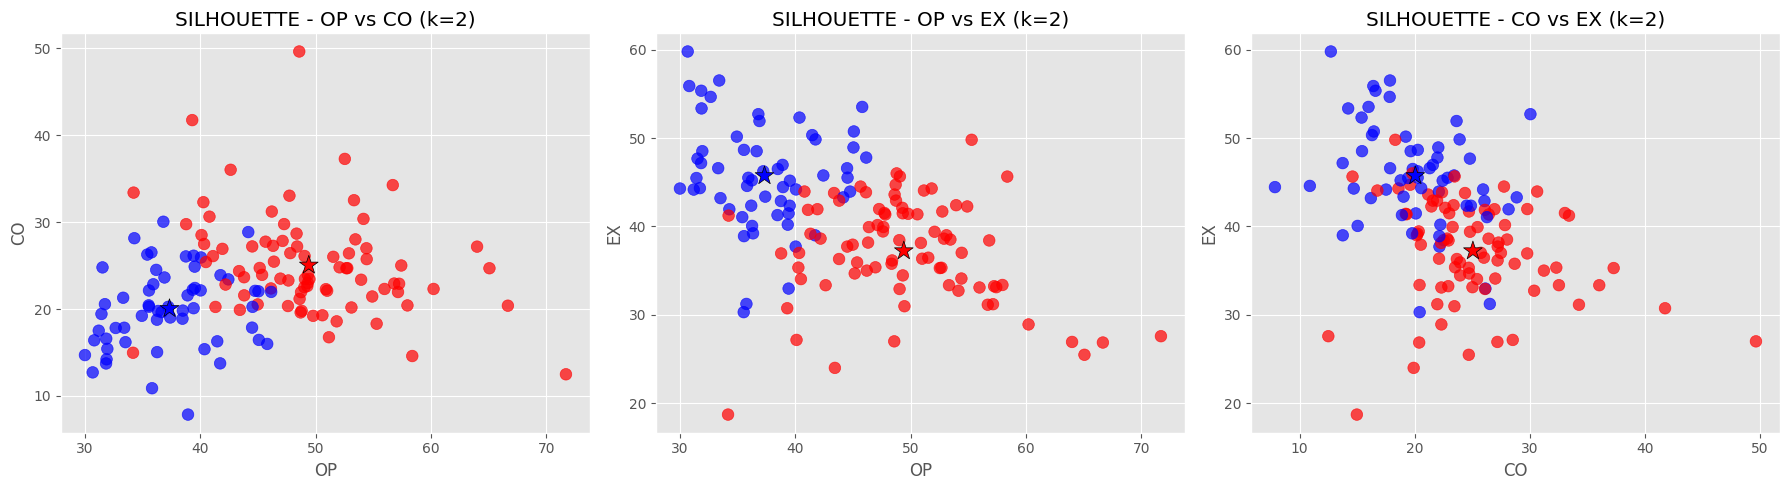

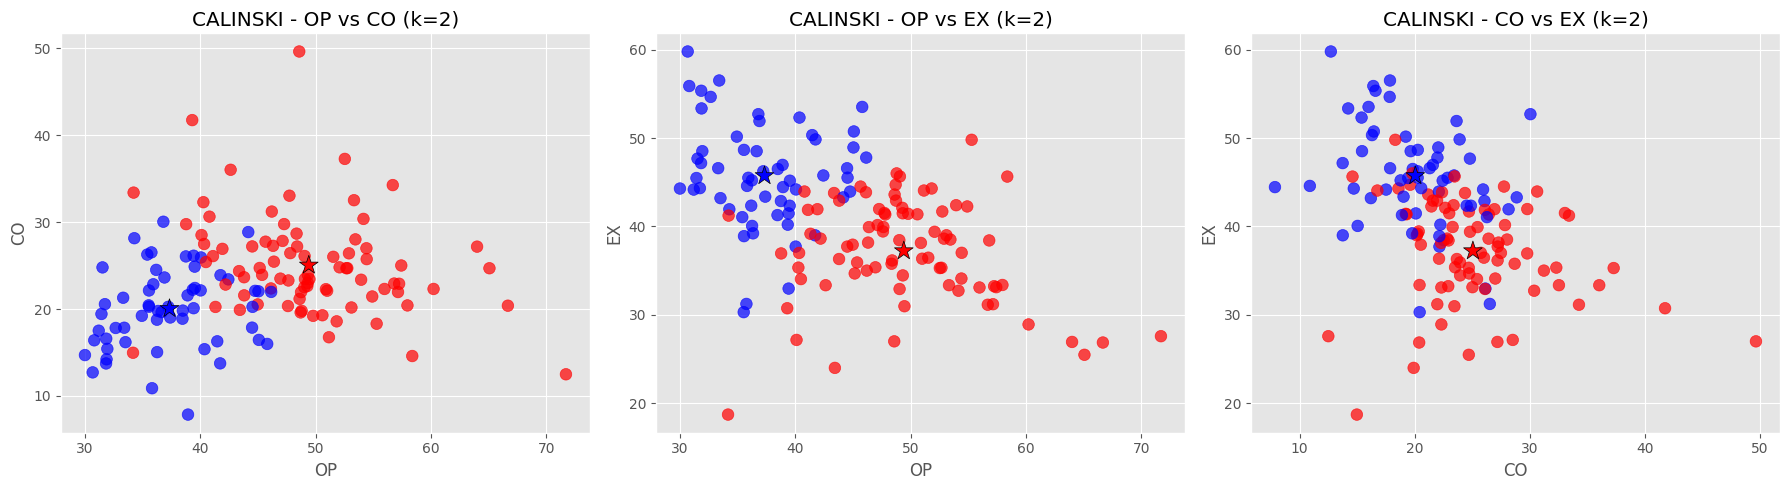

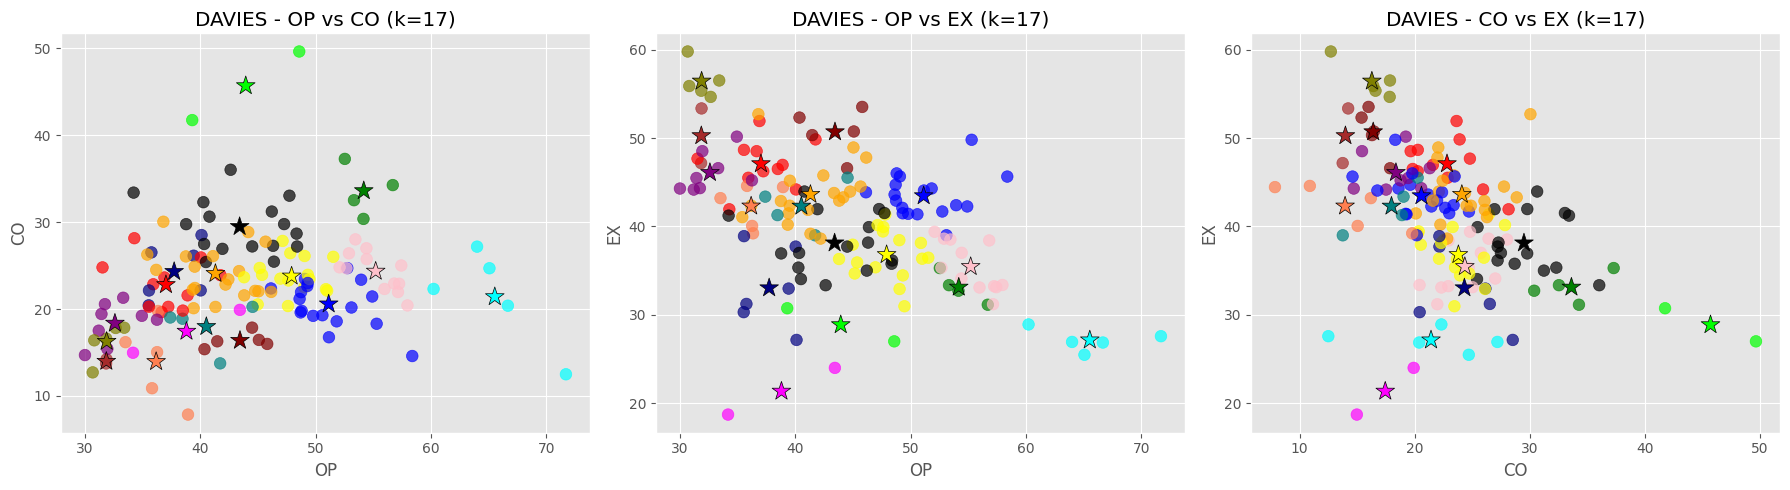

In [83]:
# Se toman las primeras tres características de las seleccionadas para los gráficos 2D
f1_name, f2_name, f3_name = seleccionadas[0], seleccionadas[1], seleccionadas[2]
f1 = dataframe[f1_name].values
f2 = dataframe[f2_name].values
f3 = dataframe[f3_name].values

for name, km in models.items():
    labels = km.predict(x)
    asignar = [colores[l] if l < len(colores) else "gray" for l in labels]
    C = km.cluster_centers_

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # feature 0 vs 1
    axs[0].scatter(f1, f2, c=asignar[:len(f1)], s=70, alpha=0.7)
    axs[0].scatter(C[:,0], C[:,1], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    axs[0].set_xlabel(f1_name.upper()); axs[0].set_ylabel(f2_name.upper())
    axs[0].set_title(f"{name.upper()} - {f1_name.upper()} vs {f2_name.upper()} (k={km.n_clusters})")

    # feature 0 vs 2
    axs[1].scatter(f1, f3, c=asignar[:len(f1)], s=70, alpha=0.7)
    axs[1].scatter(C[:,0], C[:,2], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    axs[1].set_xlabel(f1_name.upper()); axs[1].set_ylabel(f3_name.upper())
    axs[1].set_title(f"{name.upper()} - {f1_name.upper()} vs {f3_name.upper()} (k={km.n_clusters})")

    # feature 1 vs 2
    axs[2].scatter(f2, f3, c=asignar[:len(f2)], s=70, alpha=0.7)
    axs[2].scatter(C[:,1], C[:,2], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    axs[2].set_xlabel(f2_name.upper()); axs[2].set_ylabel(f3_name.upper())
    axs[2].set_title(f"{name.upper()} - {f2_name.upper()} vs {f3_name.upper()} (k={km.n_clusters})")

    plt.tight_layout()
    plt.show()


### 9. Análisis de Cantidad y Diversidad de Categorías por Cluster

Calculamos cuántos usuarios hay en cada cluster y analizamos la diversidad de categorías (profesiones) presentes en cada uno.


In [84]:
for name, km in models.items():
    labels = km.predict(x)

    # Crear DataFrame con usuario, categoría y label del cluster
    copy = pd.DataFrame()
    copy["usuario"] = dataframe["usuario"].values
    copy["categoria"] = dataframe["categoria"].values
    copy["label"] = labels

    # Cantidad de usuarios por cluster
    print(f"\n{'='*60}")
    print(f"Modelo: {name.upper()} (k={km.n_clusters})")
    print(f"{'='*60}")
    print("\nCantidad de usuarios por cluster:")
    cantidadGrupo = pd.DataFrame()
    cantidadGrupo["Color"] = colores[:km.n_clusters]
    cantidadGrupo["Cluster"] = range(km.n_clusters)
    cantidadGrupo["Cantidad"] = [np.sum(labels == i) for i in range(km.n_clusters)]
    print(cantidadGrupo.to_string(index=False))

    # Diversidad de categorías por cada cluster
    print(f"\nDiversidad de categorías por cluster:")
    for cluster_id in range(km.n_clusters):
        cluster_data = copy[copy["label"] == cluster_id]
        categoria_counts = cluster_data.groupby("categoria").size()
        print(f"\n  Cluster {cluster_id} ({colores[cluster_id]}):")
        print(f"    {dict(categoria_counts)}")



Modelo: ELBOW (k=2)

Cantidad de usuarios por cluster:
Color  Cluster  Cantidad
 blue        0        58
  red        1        82

Diversidad de categorías por cluster:

  Cluster 0 (blue):
    {1: np.int64(5), 2: np.int64(7), 3: np.int64(1), 4: np.int64(13), 5: np.int64(3), 6: np.int64(4), 7: np.int64(11), 8: np.int64(10), 9: np.int64(4)}

  Cluster 1 (red):
    {1: np.int64(22), 2: np.int64(27), 3: np.int64(8), 4: np.int64(6), 5: np.int64(1), 6: np.int64(4), 7: np.int64(6), 8: np.int64(6), 9: np.int64(2)}

Modelo: SILHOUETTE (k=2)

Cantidad de usuarios por cluster:
Color  Cluster  Cantidad
 blue        0        58
  red        1        82

Diversidad de categorías por cluster:

  Cluster 0 (blue):
    {1: np.int64(5), 2: np.int64(7), 3: np.int64(1), 4: np.int64(13), 5: np.int64(3), 6: np.int64(4), 7: np.int64(11), 8: np.int64(10), 9: np.int64(4)}

  Cluster 1 (red):
    {1: np.int64(22), 2: np.int64(27), 3: np.int64(8), 4: np.int64(6), 5: np.int64(1), 6: np.int64(4), 7: np.int64(6),

### 10. Distribución Detallada de Profesiones por Cluster

Se analiza en detalle la composición de cada cluster en términos de categorías de usuario (profesiones), mostrando el porcentaje y listando los usuarios.


In [85]:
categorias_nombres = {
    1: "Actor/Actriz",
    2: "Cantante",
    3: "Modelo",
    4: "TV, Series",
    5: "Radio",
    6: "Tecnologia",
    7: "Deportes",
    8: "Politica",
    9: "Escritores",
    0: "Ninguno" # Asumimos que 0 podría ser una categoría 'ninguno' o un error
}

for name, km in models.items():
    labels = km.predict(x)

    print(f"\n{'='*80}")
    print(f"MODELO: {name.upper()} (k={km.n_clusters})")
    print(f"{'='*80}")

    # Por cada cluster, mostrar la diversidad de categorías
    for cluster_id in range(km.n_clusters):
        cluster_index = labels == cluster_id
        cluster_data = dataframe[cluster_index]

        # Contar categorías en este cluster
        categoria_counts = cluster_data["categoria"].value_counts().sort_index()

        print(f"\n{'─'*80}")
        print(f"Cluster {cluster_id} ({colores[cluster_id]}) - Total usuarios: {len(cluster_data)}")
        print(f"{'─'*80}")

        # Mostrar distribución de categorías
        for cat_id, count in categoria_counts.items():
            porcentaje = (count / len(cluster_data)) * 100
            cat_name = categorias_nombres.get(cat_id, "Desconocida")
            print(f"  {cat_name:20s} ({cat_id}): {count:3d} usuarios ({porcentaje:5.1f}%)")

        # Mostrar usuarios en este cluster
        print(f"\n  Usuarios en cluster {cluster_id}:")
        usuarios_cluster = cluster_data[["usuario", "categoria"]].copy()
        usuarios_cluster["categoria_nombre"] = usuarios_cluster["categoria"].map(categorias_nombres)
        for idx, row in usuarios_cluster.iterrows():
            print(f"    - {row['usuario']:25s} ({row['categoria_nombre']})")



MODELO: ELBOW (k=2)

────────────────────────────────────────────────────────────────────────────────
Cluster 0 (blue) - Total usuarios: 58
────────────────────────────────────────────────────────────────────────────────
  Actor/Actriz         (1):   5 usuarios (  8.6%)
  Cantante             (2):   7 usuarios ( 12.1%)
  Modelo               (3):   1 usuarios (  1.7%)
  TV, Series           (4):  13 usuarios ( 22.4%)
  Radio                (5):   3 usuarios (  5.2%)
  Tecnologia           (6):   4 usuarios (  6.9%)
  Deportes             (7):  11 usuarios ( 19.0%)
  Politica             (8):  10 usuarios ( 17.2%)
  Escritores           (9):   4 usuarios (  6.9%)

  Usuarios en cluster 0:
    - 3gerardpique              (Deportes)
    - albertochicote            (TV, Series)
    - AlejandroSanz             (Cantante)
    - alfredocasero1            (TV, Series)
    - alo_oficial               (Deportes)
    - andresiniesta8            (Deportes)
    - andykusnetzoff            (Radio)


### 11. Clasificación de un Dato Sintético

Se clasifica un nuevo punto de datos (sintético) utilizando cada uno de los modelos K-Means entrenados, mostrando a qué cluster se asigna y las distancias a todos los centroides.


In [86]:
# x_new debe tener la misma cantidad de características que x (4 en este caso: OP, CO, EX, AG)
x_new = np.array([[45.92, 25.0, 57.74, 15.66]]) # Ejemplo con 4 valores

print(f"\n{'='*80}")
print("CLASIFICACIÓN DE DATO SINTÉTICO")
print(f"{'='*80}\n")
print(f"Valores: {seleccionadas[0].upper()}={x_new[0,0]}, {seleccionadas[1].upper()}={x_new[0,1]}, {seleccionadas[2].upper()}={x_new[0,2]}, {seleccionadas[3].upper()}={x_new[0,3]}\n")

for name, km in models.items():
    cluster_asignado = km.predict(x_new)[0]
    distancias = pairwise_distances(x_new, km.cluster_centers_)[0]

    print(f"{name.upper()}: Cluster {cluster_asignado}")
    print(f"  Distancias a todos los centroides: {distancias}")
    print()



CLASIFICACIÓN DE DATO SINTÉTICO

Valores: OP=45.92, CO=25.0, EX=57.74, AG=15.66

ELBOW: Cluster 1
  Distancias a todos los centroides: [21.22540597 20.90990344]

SILHOUETTE: Cluster 1
  Distancias a todos los centroides: [21.22540597 20.90990344]

CALINSKI: Cluster 1
  Distancias a todos los centroides: [21.22540597 20.90990344]

DAVIES: Cluster 0
  Distancias a todos los centroides: [15.84300516 20.77976884 27.36461301 36.53292663 22.08215938 16.37439873
 20.3018637  24.2025652  20.34986883 29.33551998 37.92228526 35.80959348
 26.56506592 30.17018404 17.88635645 24.31318609 23.91431918]



### 12. Métricas de Evaluación de los Modelos

Se calculan y grafican diversas métricas de evaluación para cada modelo de clustering, incluyendo Accuracy, Precision, Recall, F1-Score, ROC-AUC y Matrices de Confusión. Es importante recordar que estas métricas de clasificación supervisada se usan aquí para evaluar la correspondencia entre los clusters encontrados y las categorías originales, no la calidad intrínseca del clustering no supervisado.



MÉTRICAS DE EVALUACIÓN POR MODELO


────────────────────────────────────────────────────────────────────────────────
MODELO: ELBOW (k=2)
────────────────────────────────────────────────────────────────────────────────

  Accuracy:  0.1571
  Precision: 0.0517
  Recall:    0.1571
  F1-Score:  0.0779
  ROC-AUC:   0.5274


────────────────────────────────────────────────────────────────────────────────
MODELO: SILHOUETTE (k=2)
────────────────────────────────────────────────────────────────────────────────

  Accuracy:  0.1571
  Precision: 0.0517
  Recall:    0.1571
  F1-Score:  0.0779
  ROC-AUC:   0.5274


────────────────────────────────────────────────────────────────────────────────
MODELO: CALINSKI (k=2)
────────────────────────────────────────────────────────────────────────────────

  Accuracy:  0.1571
  Precision: 0.0517
  Recall:    0.1571
  F1-Score:  0.0779
  ROC-AUC:   0.5274


────────────────────────────────────────────────────────────────────────────────
MODELO: DAVIES (k=1

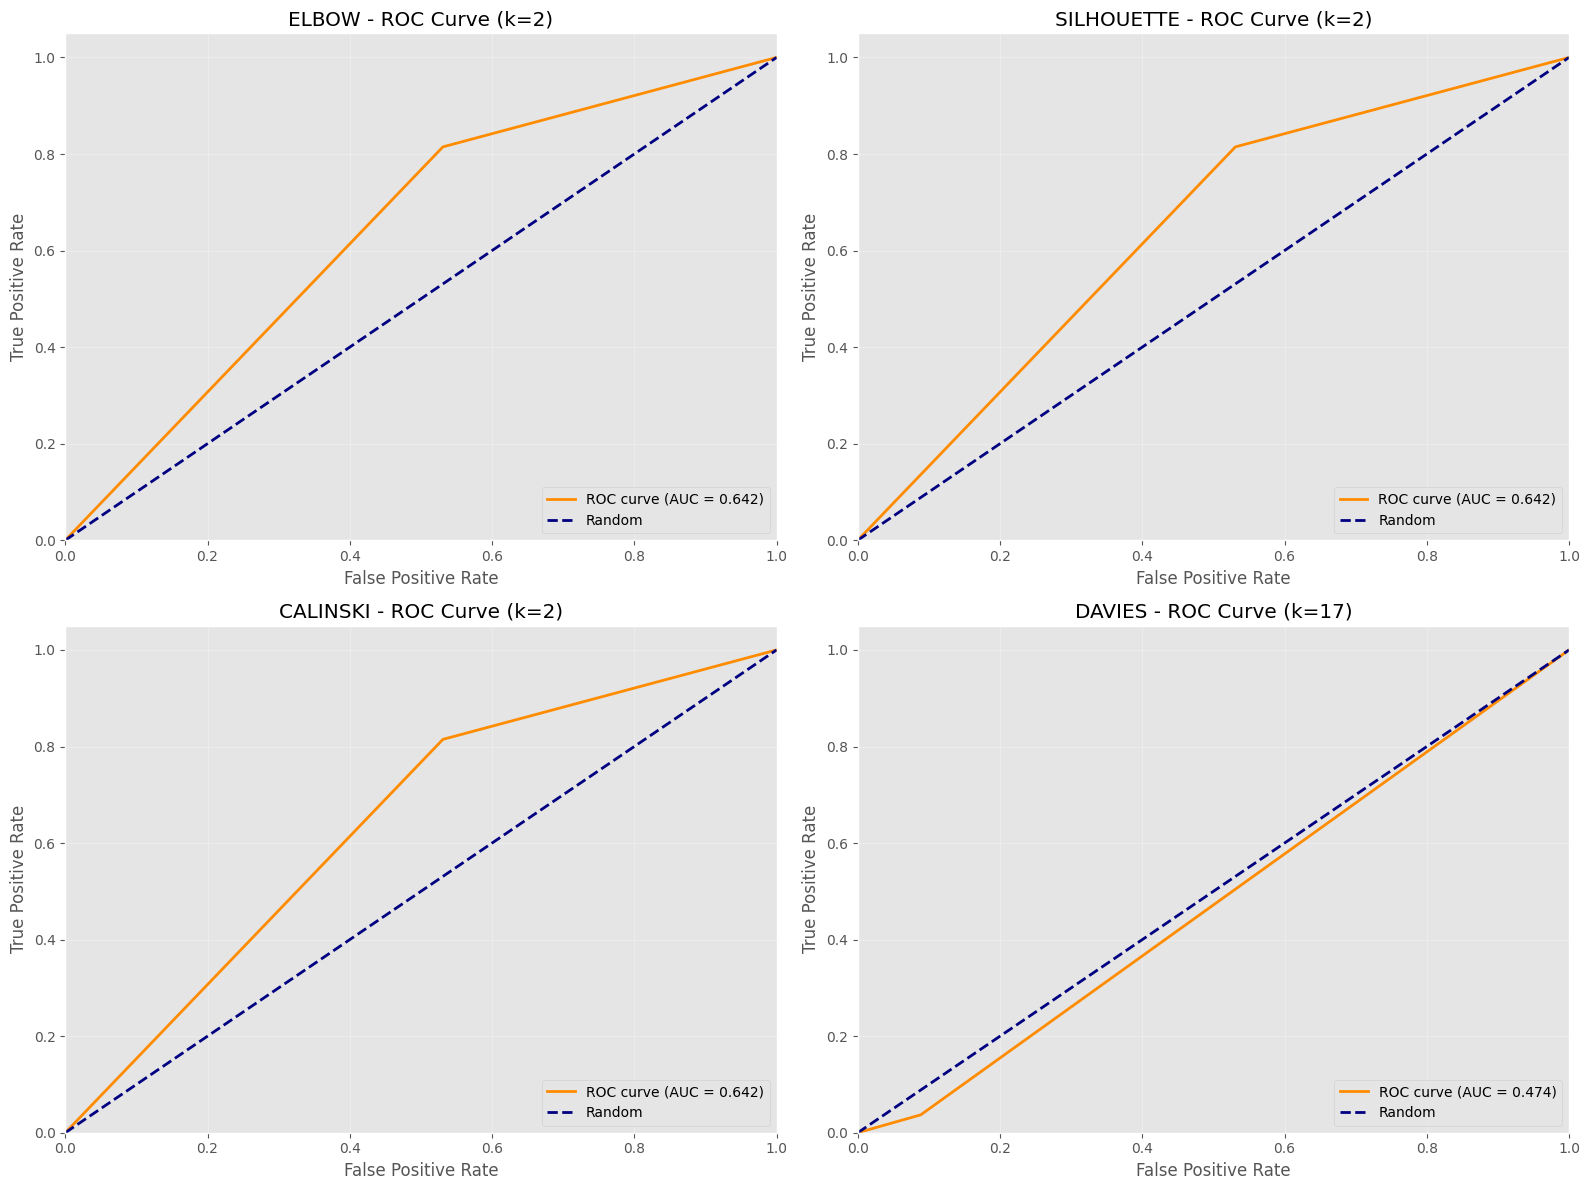


MATRICES DE CONFUSIÓN



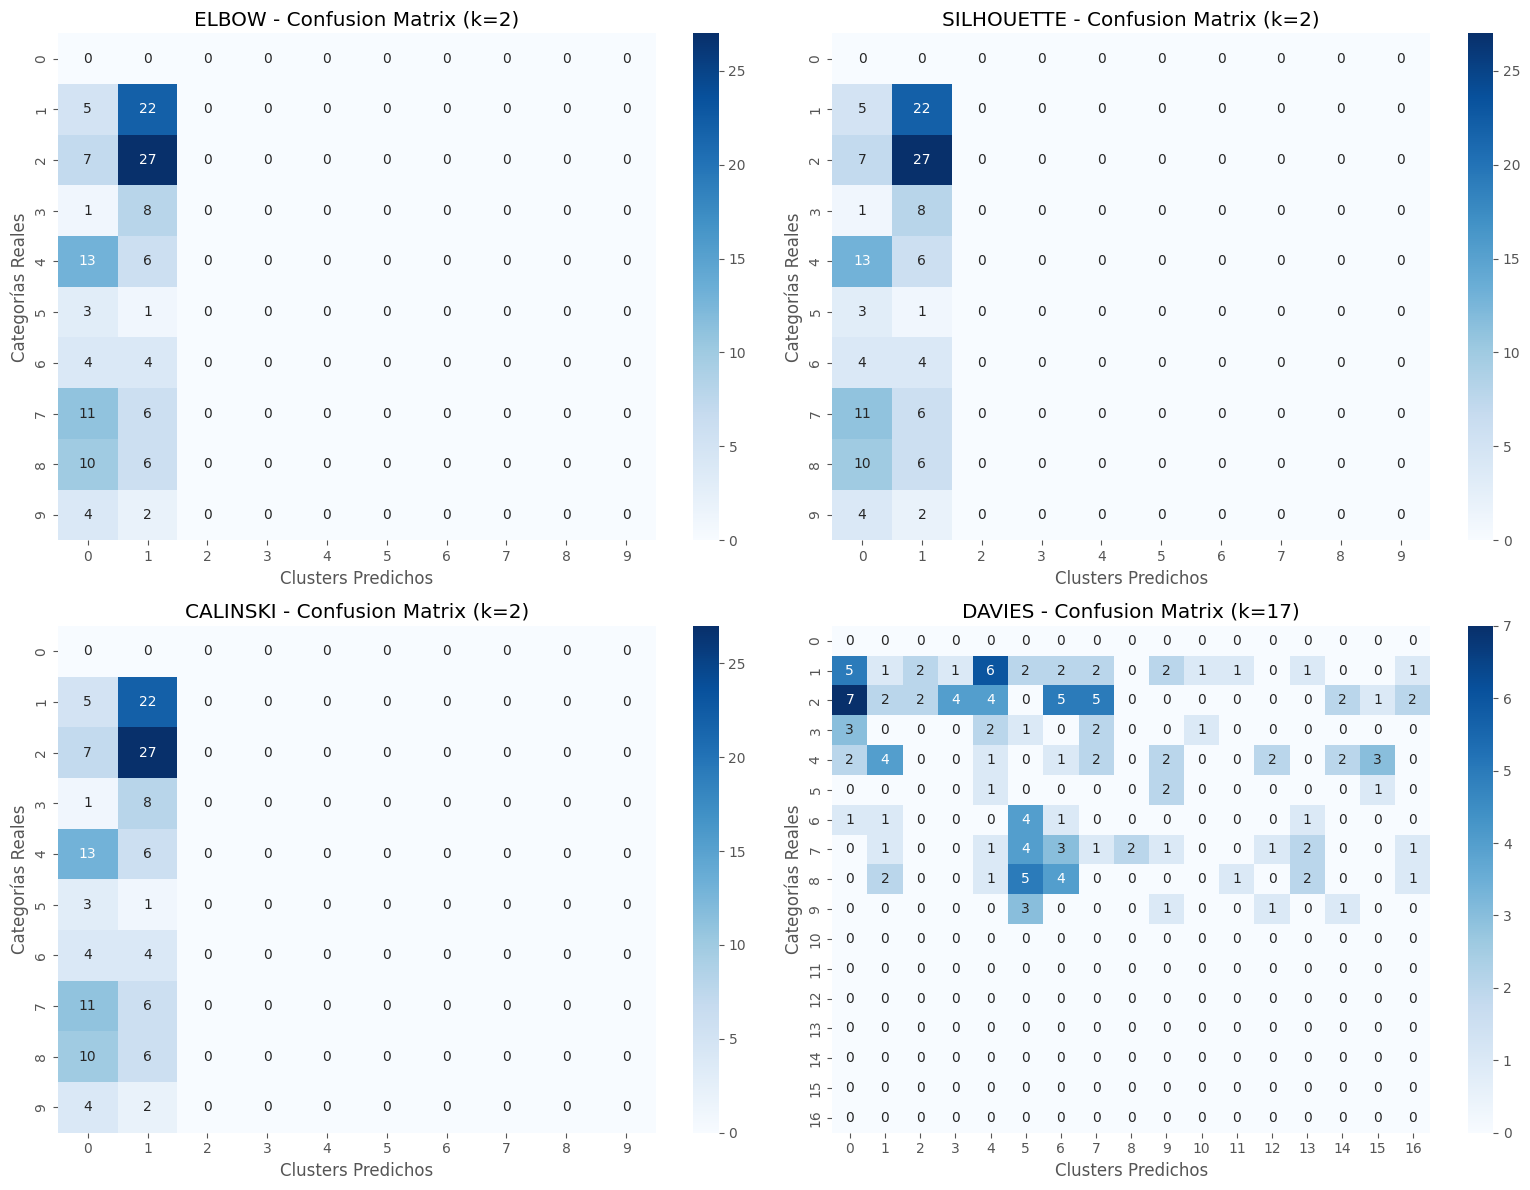


RESUMEN COMPARATIVO DE MÉTRICAS

            accuracy  precision    recall        f1   roc_auc
elbow       0.157143   0.051742  0.157143  0.077851  0.527370
silhouette  0.157143   0.051742  0.157143  0.077851  0.527370
calinski    0.157143   0.051742  0.157143  0.077851  0.527370
davies      0.050000   0.166491  0.050000  0.062728  0.491823


In [87]:
print(f"\n{'='*80}")
print("MÉTRICAS DE EVALUACIÓN POR MODELO")
print(f"{'='*80}\n")

y_true = y  # categorías reales

fig_roc, axes_roc = plt.subplots(2, 2, figsize=(16, 12))
axes_roc = axes_roc.ravel()

metricas_resultados = {}

for idx, (name, km) in enumerate(models.items()):
    print(f"\n{'─'*80}")
    print(f"MODELO: {name.upper()} (k={km.n_clusters})")
    print(f"{'─'*80}\n")

    # Predecir clusters
    y_pred = km.predict(x)

    # Calcular métricas de clasificación
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    metricas_resultados[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Calcular y graficar ROC curve (One-vs-Rest)
    try:
        # Asegurarse de que y_true y y_pred tengan las mismas clases para binarizar
        unique_classes = np.unique(np.concatenate((y_true, y_pred)))
        y_bin = label_binarize(y_true, classes=unique_classes)
        y_pred_bin = label_binarize(y_pred, classes=unique_classes)

        if y_bin.shape[1] > 1:
            roc_auc = roc_auc_score(y_bin, y_pred_bin, average='weighted', multi_class='ovr')
            print(f"  ROC-AUC:   {roc_auc:.4f}\n")
            metricas_resultados[name]['roc_auc'] = roc_auc

            # Graficar ROC curve
            fpr = dict()
            tpr = dict()
            roc_auc_curve = dict()

            for class_id in unique_classes:
                y_true_class = (y_true == class_id).astype(int)
                y_pred_class = (y_pred == class_id).astype(int)
                if len(np.unique(y_true_class)) > 1 and len(np.unique(y_pred_class)) > 1:
                    fpr[class_id], tpr[class_id], _ = roc_curve(y_true_class, y_pred_class)
                    roc_auc_curve[class_id] = roc_auc_score(y_true_class, y_pred_class)

            if roc_auc_curve:
                # Plot para la primera clase válida encontrada
                first_class_id = list(roc_auc_curve.keys())[0]
                axes_roc[idx].plot(fpr[first_class_id], tpr[first_class_id], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_curve[first_class_id]:.3f})')
                axes_roc[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
                axes_roc[idx].set_xlim([0.0, 1.0])
                axes_roc[idx].set_ylim([0.0, 1.05])
                axes_roc[idx].set_xlabel('False Positive Rate')
                axes_roc[idx].set_ylabel('True Positive Rate')
                axes_roc[idx].set_title(f'{name.upper()} - ROC Curve (k={km.n_clusters})')
                axes_roc[idx].legend(loc="lower right")
                axes_roc[idx].grid(alpha=0.3)
            else:
                print("  ROC Curve: No valid classes to plot.")
        else:
             print("  ROC-AUC:   No se puede calcular ROC-AUC con una sola clase.\n")

    except Exception as e:
        print(f"  ROC-AUC:   Error - {str(e)}\n")

plt.tight_layout()
plt.show()

# Matrices de confusión para cada modelo
print(f"\n{'='*80}")
print("MATRICES DE CONFUSIÓN")
print(f"{'='*80}\n")

fig_cm, axes_cm = plt.subplots(2, 2, figsize=(16, 12))
axes_cm = axes_cm.ravel()

for idx, (name, km) in enumerate(models.items()):
    y_pred = km.predict(x)

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Graficar heatmap
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[idx], cbar=True)
    axes_cm[idx].set_title(f'{name.upper()} - Confusion Matrix (k={km.n_clusters})')
    axes_cm[idx].set_xlabel('Clusters Predichos')
    axes_cm[idx].set_ylabel('Categorías Reales')

plt.tight_layout()
plt.show()

# Resumen comparativo
print(f"\n{'='*80}")
print("RESUMEN COMPARATIVO DE MÉTRICAS")
print(f"{'='*80}\n")

df_metricas = pd.DataFrame(metricas_resultados).T
print(df_metricas.to_string())


## Revisar el contenido del cuaderno

### Subtarea: El usuario debe revisar las celdas ya ejecutadas en el cuaderno para ver el código, los resultados de la ejecución y las explicaciones del análisis de agrupamiento. El error `FileNotFoundError` se resolvió y el análisis se completó correctamente.

#### Instrucciones
1. Desplácese por el cuaderno para examinar todas las celdas ejecutadas.

2. Preste mucha atención al código utilizado para el análisis de agrupamiento.

3. Revise la salida y los resultados generados por la ejecución del código de agrupamiento.

4. Lea las explicaciones o interpretaciones del análisis de agrupamiento que se incluyen en el cuaderno.

## Tarea final

### Subtarea: Confirmar que el usuario ha revisado correctamente el contenido del cuaderno y que se han satisfecho todos los aspectos de su solicitud de código, ejecución y explicaciones.

## Resumen:

### Hallazgos clave del análisis de datos
* Se agregó correctamente un bloque de Markdown con instrucciones detalladas para revisar el cuaderno.

* Estas instrucciones guiaron al usuario en el examen del código, los resultados de ejecución y las explicaciones del análisis de agrupamiento.

* Se resolvió el error `FileNotFoundError` que se había producido anteriormente y el análisis de agrupamiento se completó correctamente.

* La subtarea de confirmar la revisión se consideró completada al proporcionar estas instrucciones para la revisión del usuario.

### Información adicional o próximos pasos
* El usuario debe seguir las instrucciones proporcionadas para revisar exhaustivamente el análisis de agrupamiento, incluyendo su código, ejecución y explicaciones.

* El sistema configuró correctamente el siguiente paso para que el usuario interactúe con el análisis completado.